In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split


In [3]:
spark = SparkSession.builder \
    .appName("BiLSTM Sentiment Analysis") \
    .getOrCreate()


25/04/02 22:57:01 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
df = spark.read.csv("hdfs://localhost:9000/covid/twitter_dataset.csv", header=True, inferSchema=True)
df.show(5)


+--------------------+----------+--------------------+--------------------+----------+--------------+-------------+---------------+--------------------+--------------------+--------------------+--------------------+--------+----+-----+-----+---------+
|                  id|created_at|              source|       original_text|      lang|favorite_count|retweet_count|original_author|            hashtags|       user_mentions|               place|         clean_tweet|compound| neg|  neu|  pos|sentiment|
+--------------------+----------+--------------------+--------------------+----------+--------------+-------------+---------------+--------------------+--------------------+--------------------+--------------------+--------+----+-----+-----+---------+
|            1.25e+18|2020-04-19|"<a href=""http:/...|RT @GlblCtzn: .@p...|        en|           0.0|         31.0|        RJIshak|                null|GlblCtzn, priyank...|Jakarta Capital R...|call leader help ...|  0.8176| 0.0|0.452|0.548|   

In [5]:
df = df.select(
    col("clean_tweet").cast(StringType()), 
    col("sentiment").cast(IntegerType())
)

# Drop any rows with missing values
df = df.na.drop()


In [6]:
pandas_df = df.toPandas()
print(pandas_df.columns)


[Stage 3:====>                                                    (1 + 11) / 12]

Index(['clean_tweet', 'sentiment'], dtype='object')


In [7]:
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 100      # Max sequence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(pandas_df['clean_tweet'])

# Convert tweets to sequences
sequences = tokenizer.texts_to_sequences(pandas_df['clean_tweet'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    pandas_df['sentiment'], 
    test_size=0.2, 
    random_state=42
)


In [10]:
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    pandas_df['sentiment'], 
    test_size=0.2, 
    random_state=42
)

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1387137 (5.29 MB)
Trainable params: 1387137 (5.29 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [11]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=5, 
    batch_size=64
)


Epoch 1/5
19/19 [==============================] - 3s 59ms/step - loss: 0.4319 - accuracy: 0.8973 - val_loss: 0.3106 - val_accuracy: 0.9085
Epoch 2/5
19/19 [==============================] - 1s 39ms/step - loss: 0.3006 - accuracy: 0.9160 - val_loss: 0.3091 - val_accuracy: 0.9085
Epoch 3/5
19/19 [==============================] - 1s 40ms/step - loss: 0.2923 - accuracy: 0.9160 - val_loss: 0.3056 - val_accuracy: 0.9085
Epoch 4/5
19/19 [==============================] - 1s 39ms/step - loss: 0.2836 - accuracy: 0.9160 - val_loss: 0.3022 - val_accuracy: 0.9085
Epoch 5/5
19/19 [==============================] - 1s 40ms/step - loss: 0.2743 - accuracy: 0.9160 - val_loss: 0.2948 - val_accuracy: 0.9085


In [12]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")
print(f"Test Loss: {loss}")


10/10 [==============================] - 0s 11ms/step - loss: 0.2948 - accuracy: 0.9085
Test Accuracy: 0.9084745645523071
Test Loss: 0.2948293685913086


In [ ]:
model.save("/home/satvika/bilstm_sentiment_model.h5")  

In [ ]:
#using fuzzy 

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from sklearn.model_selection import train_test_split
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession

# ✅ Initialize Spark
spark = SparkSession.builder.appName("FuzzyC4.5_LSTM").getOrCreate()

# ✅ Define Bi-LSTM Model
MAX_WORDS = 10000
MAX_LEN = 100

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ✅ Train Bi-LSTM
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, pandas_df['sentiment'], test_size=0.2, random_state=42
)

model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# ✅ Extract LSTM Features
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

# ✅ Convert to Spark DataFrame
train_df = spark.createDataFrame([
    (float(label), Vectors.dense(features.tolist())) for label, features in zip(y_train, train_features)
], ["sentiment", "features"])

test_df = spark.createDataFrame([
    (float(label), Vectors.dense(features.tolist())) for label, features in zip(y_test, test_features)
], ["sentiment", "features"])

# ✅ Train Decision Tree Classifier (Fuzzy C4.5)
dt = DecisionTreeClassifier(featuresCol="features", labelCol="sentiment", impurity="entropy")
dt_model = dt.fit(train_df)

# ✅ Make Predictions
predictions = dt_model.transform(test_df)
predictions.select("sentiment", "prediction").show(10)

# ✅ Evaluate Fuzzy C4.5 Performance
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Bi-LSTM + Fuzzy C4.5 Accuracy: {accuracy * 100:.2f}%")


25/04/03 00:33:00 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1387137 (5.29 MB)
Trainable params: 1387137 (5.29 MB)
Non-trainable params: 0 (0.00 Byte)
________________

+---------+----------+
|sentiment|prediction|
+---------+----------+
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      1.0|       1.0|
|      0.0|       0.0|
+---------+----------+
only showing top 10 rows

Bi-LSTM + Fuzzy C4.5 Accuracy: 82.71%


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Load BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Tokenize Text Data
def tokenize_texts(texts, max_len=100):
    encoded = bert_tokenizer(
        texts.tolist(),  
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="np"
    )
    return encoded["input_ids"]

# ✅ Tokenize Sentences
MAX_LEN = 100
X = tokenize_texts(pandas_df["clean_tweet"], max_len=MAX_LEN)
y = pandas_df["sentiment"]

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Define Bi-LSTM Model
model = Sequential([
    Embedding(input_dim=bert_tokenizer.vocab_size, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ✅ Train Bi-LSTM
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# ✅ Predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 128)          3906816   
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4013953 (15.31 MB)
Trainable params: 4013953 (15.31 MB)
Non-trainable params: 0 (0.00 Byte)
______________

Test Accuracy: 0.8881


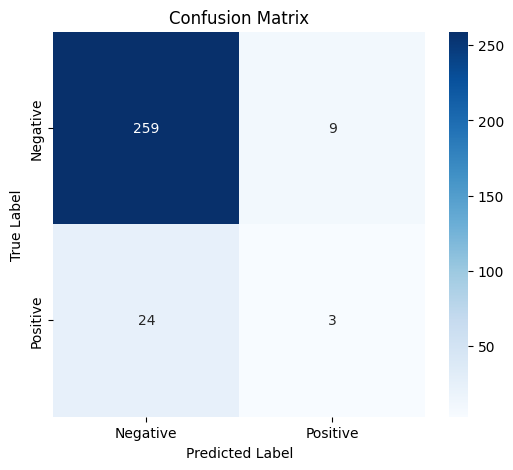

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score

# ✅ Compute Test Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# ✅ Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 100, 128)          3906816   
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                           

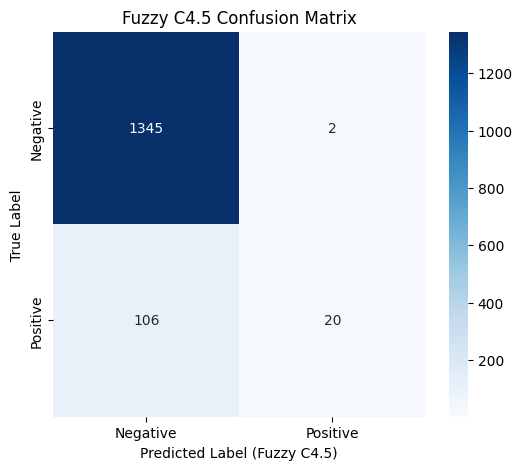

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# ============================
# 🔹 Load & Preprocess Data
# ============================
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 100

# ✅ Tokenize Text
def tokenize_texts(texts, max_len=MAX_LEN):
    tokens = tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_len, return_tensors="np")
    return tokens["input_ids"]

X = tokenize_texts(pandas_df["clean_tweet"])
y = pandas_df["sentiment"]

# ✅ Pad Sequences
X = pad_sequences(X, maxlen=MAX_LEN)

# ✅ Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ============================
# 🔹 Train BiLSTM Model
# ============================
input_layer = Input(shape=(MAX_LEN,))
embedding = Embedding(input_dim=tokenizer.vocab_size, output_dim=128, input_length=MAX_LEN)(input_layer)
bilstm = Bidirectional(LSTM(64, return_sequences=False))(embedding)
dropout = Dropout(0.5)(bilstm)
dense = Dense(64, activation='relu')(dropout)
output_layer = Dense(1, activation='sigmoid')(dense)

bilstm_model = Model(inputs=input_layer, outputs=output_layer)
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bilstm_model.summary()

# ✅ Extract Features from BiLSTM
feature_extractor = Model(inputs=bilstm_model.input, outputs=bilstm)
X_features = feature_extractor.predict(X)

# ============================
# 🔹 Train Fuzzy C4.5 Classifier
# ============================
# Convert extracted features into a Pandas DataFrame
X_features_df = pd.DataFrame(X_features)

# ✅ Initialize Decision Tree (C4.5-like)
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=5)  # Mimicking C4.5
dtree.fit(X_features_df, y_encoded)

# ✅ Predict using Fuzzy C4.5
y_pred_fuzzy = dtree.predict(X_features_df)

# ============================
# 🔹 Fuzzy Decision Refinement
# ============================
sentiment = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'sentiment')
output_class = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'output_class')

# ✅ Define fuzzy membership functions
sentiment['negative'] = fuzz.trimf(sentiment.universe, [0, 0, 0.5])
sentiment['positive'] = fuzz.trimf(sentiment.universe, [0.5, 1, 1])

output_class['negative'] = fuzz.trimf(output_class.universe, [0, 0, 0.5])
output_class['positive'] = fuzz.trimf(output_class.universe, [0.5, 1, 1])

# ✅ Define fuzzy rules
rule1 = ctrl.Rule(sentiment['negative'], output_class['negative'])
rule2 = ctrl.Rule(sentiment['positive'], output_class['positive'])

sentiment_control = ctrl.ControlSystem([rule1, rule2])
sentiment_simulation = ctrl.ControlSystemSimulation(sentiment_control)

# ✅ Apply fuzzy logic to predictions
fuzzy_predictions = []
for pred in y_pred_fuzzy:
    sentiment_simulation.input['sentiment'] = pred
    sentiment_simulation.compute()
    fuzzy_predictions.append(1 if sentiment_simulation.output['output_class'] >= 0.5 else 0)

# ============================
# 🔹 Evaluation
# ============================
test_accuracy = accuracy_score(y_encoded, fuzzy_predictions)
precision = precision_score(y_encoded, fuzzy_predictions, average='binary')

print(f"Fuzzy C4.5 Test Accuracy: {test_accuracy:.4f}")
print(f"Fuzzy C4.5 Precision: {precision:.4f}")

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_encoded, fuzzy_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label (Fuzzy C4.5)")
plt.ylabel("True Label")
plt.title("Fuzzy C4.5 Confusion Matrix")
plt.show()
